In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread, mmwrite
from scipy.stats import pearsonr, spearmanr

In [2]:
projdir = '/u/home/t/terencew/project-cluo/igvf/pilot/multiome/'
donors = list(np.loadtxt(f'{projdir}/txt/donors.txt', dtype=str))
samples = list(np.loadtxt(f'{projdir}/txt/samples.txt', dtype=str))
s = samples[0]

gex_methods = ['demuxlet', 'freemuxlet', 'vireo', 'vireo_nogenos',
    'souporcell', 'souporcell_nogenos', 'demuxalot']
atac_methods = ['demuxlet', 'freemuxlet',  'vireo', 'vireo_nogenos',
    'souporcell', 'souporcell_nogenos']

con_cols = ['C1', 'C2', 'I1', 'I2']
cov_thresh = [0, 10, 20]
final_con_cols = ['C1', 'C2', 'I1', 'I2', 'DP', 'Consistent rate', 'Inconsistent rate',
       'C1 rate', 'C2 rate', 'I1 rate', 'I2 rate']

In [3]:
pd_exps = ['0_20', '10_20', '20_20', '30_20']
mux_exps = ['2_20', '6_20', '8_20', '10_20', '12_20', '14_20', '16_20']

In [4]:
def process_con(con):
    con['DP'] = np.sum(con.iloc[:,:4], axis=1)
    con['Consistent rate'] = (con['C1'] + con['C2']) / con['DP']
    con['Inconsistent rate'] = 1 - con['Consistent rate']
    con['C1 rate'] = con['C1'] / con['DP']
    con['C2 rate'] = con['C2'] / con['DP']
    con['I1 rate'] = con['I1'] / con['DP']
    con['I2 rate'] = con['I2'] / con['DP']
    return con

In [5]:
def process_truth(truth_dir, barcodes):
    truth = pd.read_csv(f'{truth_dir}/drop_data_rand.txt', sep='\t', header=0, index_col=0)
    truth['barcode'] = [f'{x}-1' for x in truth.index]
    truth.index = [f'{x}_D0' for x in truth['barcode']]
    mask = truth.index.isin(barcodes)
    truth = truth[mask]
    doub_mask = [',' in x for x in truth['sam']]
    truth.loc[doub_mask,'sam'] = ['doublet'] * sum(doub_mask)
    truth.sort_index(inplace=True)
    truth['ambient_RNA'] = truth['rna_nr_a'] / (truth['rna_nr_c']  + truth['rna_nr_a'])
    truth['ambient_DNA'] = truth['atac_nr_a'] / (truth['atac_nr_c']  + truth['atac_nr_a'])
    truth['ambient_DNA_peaks'] = truth['atac_nr_ap'] / (truth['atac_nr_cp']  + truth['atac_nr_ap'])
    return truth

### read truth

In [6]:
# exp = '0_20'
# truth_dir = f'{projdir}/ambient/ambisim/prop_doub/{exp}/{s}/'
# gex_truth_con = pd.read_csv(f'{projdir}/{exp}/var_consistency/gex/{s}/{exp}_cov{cov}_truth.csv', sep='\t', header=0, index_col=0)
# barcodes = gex_truth_con.index
# truth = process_truth(truth_dir, barcodes)
# truth

In [7]:
cov = 0
indir = f'{projdir}/ambient/ambisim/prop_doub/csv/var_consistency/'
exp = pd_exps[0]

select_cols = ['rna_nr_a', 'atac_nr_a', 'atac_nr_ap', 
               'ambient_RNA', 'ambient_RNA', 'ambient_DNA', 'ambient_DNA_peaks']

gex_pd_exps = pd.DataFrame()
atac_pd_exps = pd.DataFrame()

for exp in pd_exps:
    print(exp)
    gex_truth_con = pd.read_csv(f'{indir}/gex/{s}/{exp}_cov{cov}_truth.csv', sep='\t', header=0, index_col=0)
    atac_truth_con = pd.read_csv(f'{indir}/atac/{s}/{exp}_cov{cov}_truth.csv', sep='\t', header=0, index_col=0)
    
    truth_dir = f'{projdir}/ambient/ambisim/prop_doub/{exp}/{s}/'
    barcodes = gex_truth_con.index
    truth = process_truth(truth_dir, barcodes)
    for col in select_cols:
        gex_truth_con[col] = truth[col]
    gex_truth_con['exp'] = exp
    
    for col in select_cols:
        atac_truth_con[col] = truth[col]
    atac_truth_con['exp'] = exp
    
    gex_pd_exps = pd.concat([gex_pd_exps, gex_truth_con])
    atac_pd_exps = pd.concat([atac_pd_exps, atac_truth_con])

0_20


/u/home/t/terencew/project-cluo/miniconda3/envs/allcools/lib/python3.7/site-packages/ipykernel_launcher.py:18: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.


10_20
20_20
30_20


In [8]:
gex_pd_exps

,C1,C2,I1,I2,donor,rna_nr_a,atac_nr_a,atac_nr_ap,ambient_RNA,ambient_DNA,ambient_DNA_peaks,exp
AAACAGCCAAACGCGA-1_D0,62,1176,12,7,25_A4,0,0,0,0.000000,0.000000,0.000000,0_20
AAACAGCCAAACTAAG-1_D0,29,605,4,3,25_A4,0,0,0,0.000000,0.000000,0.000000,0_20
AAACAGCCAAAGCTCC-1_D0,33,543,4,3,25_A4,0,0,0,0.000000,0.000000,0.000000,0_20
AAACAGCCAAATACCT-1_D0,40,755,6,3,25_A4,0,0,0,0.000000,0.000000,0.000000,0_20
AAACAGCCAAATATCC-1_D0,63,1197,10,5,25_A4,0,0,0,0.000000,0.000000,0.000000,0_20
...,...,...,...,...,...,...,...,...,...,...,...,...
AAAGGTTAGTAAGGGC-1_D0,37,977,66,11,48_V3,3912,486,124,0.403050,0.124138,0.234848,30_20
AAAGGTTAGTAAGTGG-1_D0,9,232,27,1,48_V3,1360,470,53,0.544654,0.254881,0.087748,30_20
AAAGGTTAGTAATCCA-1_D0,21,423,24,2,48_V3,1369,694,41,0.362457,0.279388,0.038679,30_20
AAAGGTTAGTACCGCA-1_D0,23,576,40,5,48_V3,1843,1045,413,0.327121,0.103476,0.102431,30_20


In [9]:
cov = 0
indir = f'{projdir}/ambient/ambisim/mux_test/csv/var_consistency/'
exp = mux_exps[0]

select_cols = ['rna_nr_a', 'atac_nr_a', 'atac_nr_ap', 
               'ambient_RNA', 'ambient_RNA', 'ambient_DNA', 'ambient_DNA_peaks']
gex_mux_exps = pd.DataFrame()
atac_mux_exps = pd.DataFrame()

for exp in mux_exps:
    print(exp)
    gex_truth_con = pd.read_csv(f'{indir}/gex/{s}/{exp}_cov{cov}_truth.csv', sep='\t', header=0, index_col=0)
    atac_truth_con = pd.read_csv(f'{indir}/atac/{s}/{exp}_cov{cov}_truth.csv', sep='\t', header=0, index_col=0)
    
    truth_dir = f'{projdir}/ambient/ambisim/mux_test/{exp}/{s}/'
    barcodes = gex_truth_con.index
    truth = process_truth(truth_dir, barcodes)
    for col in select_cols:
        gex_truth_con[col] = truth[col]
    gex_truth_con['exp'] = exp
    
    for col in select_cols:
        atac_truth_con[col] = truth[col]
    atac_truth_con['exp'] = exp
    
    gex_mux_exps = pd.concat([gex_mux_exps, gex_truth_con])
    atac_mux_exps = pd.concat([atac_mux_exps, atac_truth_con])


2_20


/u/home/t/terencew/project-cluo/miniconda3/envs/allcools/lib/python3.7/site-packages/ipykernel_launcher.py:17: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.


6_20
8_20
10_20
12_20
14_20
16_20


In [10]:
gex_mux_exps

,C1,C2,I1,I2,donor,rna_nr_a,atac_nr_a,atac_nr_ap,ambient_RNA,ambient_DNA,ambient_DNA_peaks,exp
AAACAGCCAAACAACA-1_D0,334,1261,27,5,22_C21,775,270,52,0.056151,0.066502,0.031553,2_20
AAACAGCCAAACCCTA-1_D0,100,415,34,3,22_C21,1373,994,6,0.272313,0.244406,0.007653,2_20
AAACAGCCAAACCTAT-1_D0,310,1358,50,11,22_C21,2144,2775,2,0.138198,0.330279,0.000894,2_20
AAACAGCCAAACGCGA-1_D0,85,323,26,2,22_C21,900,230,5,0.238790,0.053676,0.004125,2_20
AAACAGCCAAAGCCTC-1_D0,152,558,22,2,22_C21,911,1250,44,0.162679,0.307579,0.032787,2_20
...,...,...,...,...,...,...,...,...,...,...,...,...
AAATGCCTCTCGCCTG-1_D0,3,321,23,0,18_A9,974,2047,399,0.300617,0.139365,0.047608,16_20
AAATGGCCAAACGCGA-1_D0,6,779,25,1,18_A9,656,478,50,0.088553,0.282006,0.075075,16_20
AAATGGCCAAACTGTT-1_D0,1,293,30,0,18_A9,1911,91,4,0.540136,0.062543,0.004545,16_20
AAATGGCCAACTAGAA-1_D0,2,197,5,1,18_A9,73,6097,372,0.036720,0.254360,0.058025,16_20


In [11]:
# pd.corr(gex_mux_exps['atac_nr_a'])
gex_pd_final = process_con(gex_pd_exps)
atac_pd_final = process_con(atac_pd_exps)
gex_mux_final = process_con(gex_mux_exps)
atac_mux_final = process_con(atac_mux_exps)

In [12]:
gex_mux_final['I1 rate']

AAACAGCCAAACAACA-1_D0    0.016595
AAACAGCCAAACCCTA-1_D0    0.061594
AAACAGCCAAACCTAT-1_D0    0.028918
AAACAGCCAAACGCGA-1_D0    0.059633
AAACAGCCAAAGCCTC-1_D0    0.029973
                           ...   
AAATGCCTCTCGCCTG-1_D0    0.066282
AAATGGCCAAACGCGA-1_D0    0.030826
AAATGGCCAAACTGTT-1_D0    0.092593
AAATGGCCAACTAGAA-1_D0    0.024390
AAATGGCCAAGACTCC-1_D0    0.041667
Name: I1 rate, Length: 53559, dtype: float64

In [13]:
gex_mux_final

,C1,C2,I1,I2,donor,rna_nr_a,atac_nr_a,atac_nr_ap,ambient_RNA,ambient_DNA,ambient_DNA_peaks,exp,DP,Consistent rate,Inconsistent rate,C1 rate,C2 rate,I1 rate,I2 rate
AAACAGCCAAACAACA-1_D0,334,1261,27,5,22_C21,775,270,52,0.056151,0.066502,0.031553,2_20,1627,0.980332,0.019668,0.205286,0.775046,0.016595,0.003073
AAACAGCCAAACCCTA-1_D0,100,415,34,3,22_C21,1373,994,6,0.272313,0.244406,0.007653,2_20,552,0.932971,0.067029,0.181159,0.751812,0.061594,0.005435
AAACAGCCAAACCTAT-1_D0,310,1358,50,11,22_C21,2144,2775,2,0.138198,0.330279,0.000894,2_20,1729,0.964719,0.035281,0.179294,0.785425,0.028918,0.006362
AAACAGCCAAACGCGA-1_D0,85,323,26,2,22_C21,900,230,5,0.238790,0.053676,0.004125,2_20,436,0.935780,0.064220,0.194954,0.740826,0.059633,0.004587
AAACAGCCAAAGCCTC-1_D0,152,558,22,2,22_C21,911,1250,44,0.162679,0.307579,0.032787,2_20,734,0.967302,0.032698,0.207084,0.760218,0.029973,0.002725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAATGCCTCTCGCCTG-1_D0,3,321,23,0,18_A9,974,2047,399,0.300617,0.139365,0.047608,16_20,347,0.933718,0.066282,0.008646,0.925072,0.066282,0.000000
AAATGGCCAAACGCGA-1_D0,6,779,25,1,18_A9,656,478,50,0.088553,0.282006,0.075075,16_20,811,0.967941,0.032059,0.007398,0.960543,0.030826,0.001233
AAATGGCCAAACTGTT-1_D0,1,293,30,0,18_A9,1911,91,4,0.540136,0.062543,0.004545,16_20,324,0.907407,0.092593,0.003086,0.904321,0.092593,0.000000
AAATGGCCAACTAGAA-1_D0,2,197,5,1,18_A9,73,6097,372,0.036720,0.254360,0.058025,16_20,205,0.970732,0.029268,0.009756,0.960976,0.024390,0.004878


In [14]:
### noice
select = ['C1', 'C2', 'I1', 'I2','rna_nr_a']
pd.DataFrame(gex_mux_final[select]).corr(method='spearman')
# pd.DataFrame(gex_mux_final)

,C1,C2,I1,I2,rna_nr_a
C1,1.000000,0.450204,0.263085,0.550890,0.262979
C2,0.450204,1.000000,0.716097,0.551135,0.641492
I1,0.263085,0.716097,1.000000,0.435411,0.935367
I2,0.550890,0.551135,0.435411,1.000000,0.364756
rna_nr_a,0.262979,0.641492,0.935367,0.364756,1.000000


In [15]:
gex_mux_final

,C1,C2,I1,I2,donor,rna_nr_a,atac_nr_a,atac_nr_ap,ambient_RNA,ambient_DNA,ambient_DNA_peaks,exp,DP,Consistent rate,Inconsistent rate,C1 rate,C2 rate,I1 rate,I2 rate
AAACAGCCAAACAACA-1_D0,334,1261,27,5,22_C21,775,270,52,0.056151,0.066502,0.031553,2_20,1627,0.980332,0.019668,0.205286,0.775046,0.016595,0.003073
AAACAGCCAAACCCTA-1_D0,100,415,34,3,22_C21,1373,994,6,0.272313,0.244406,0.007653,2_20,552,0.932971,0.067029,0.181159,0.751812,0.061594,0.005435
AAACAGCCAAACCTAT-1_D0,310,1358,50,11,22_C21,2144,2775,2,0.138198,0.330279,0.000894,2_20,1729,0.964719,0.035281,0.179294,0.785425,0.028918,0.006362
AAACAGCCAAACGCGA-1_D0,85,323,26,2,22_C21,900,230,5,0.238790,0.053676,0.004125,2_20,436,0.935780,0.064220,0.194954,0.740826,0.059633,0.004587
AAACAGCCAAAGCCTC-1_D0,152,558,22,2,22_C21,911,1250,44,0.162679,0.307579,0.032787,2_20,734,0.967302,0.032698,0.207084,0.760218,0.029973,0.002725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAATGCCTCTCGCCTG-1_D0,3,321,23,0,18_A9,974,2047,399,0.300617,0.139365,0.047608,16_20,347,0.933718,0.066282,0.008646,0.925072,0.066282,0.000000
AAATGGCCAAACGCGA-1_D0,6,779,25,1,18_A9,656,478,50,0.088553,0.282006,0.075075,16_20,811,0.967941,0.032059,0.007398,0.960543,0.030826,0.001233
AAATGGCCAAACTGTT-1_D0,1,293,30,0,18_A9,1911,91,4,0.540136,0.062543,0.004545,16_20,324,0.907407,0.092593,0.003086,0.904321,0.092593,0.000000
AAATGGCCAACTAGAA-1_D0,2,197,5,1,18_A9,73,6097,372,0.036720,0.254360,0.058025,16_20,205,0.970732,0.029268,0.009756,0.960976,0.024390,0.004878


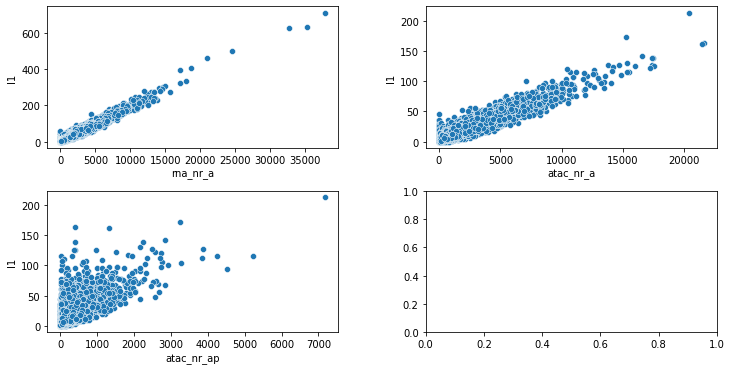

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
ax = axes[0][0]
sns.scatterplot(gex_pd_final, x='rna_nr_a', y='I1',ax=ax)
ax = axes[0][1]
sns.scatterplot(atac_pd_final, x='atac_nr_a', y='I1',ax=ax)
ax = axes[1][0]
sns.scatterplot(atac_pd_final, x='atac_nr_ap', y='I1',ax=ax)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

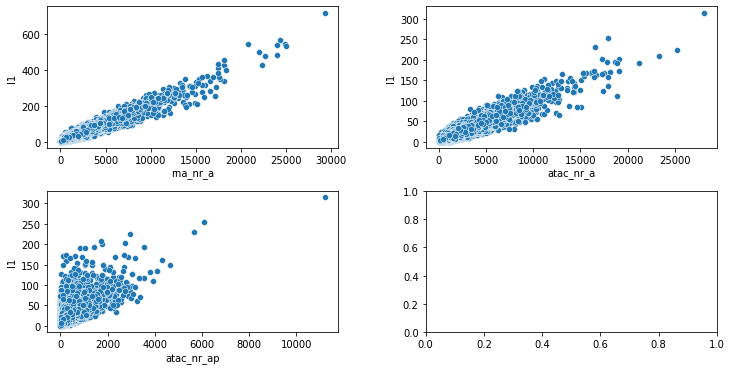

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
ax = axes[0][0]
sns.scatterplot(gex_mux_final, x='rna_nr_a', y='I1',ax=ax)
ax = axes[0][1]
sns.scatterplot(atac_mux_final, x='atac_nr_a', y='I1',ax=ax)
ax = axes[1][0]
sns.scatterplot(atac_mux_final, x='atac_nr_ap', y='I1',ax=ax)
plt.subplots_adjust(hspace=0.3, wspace=0.3)

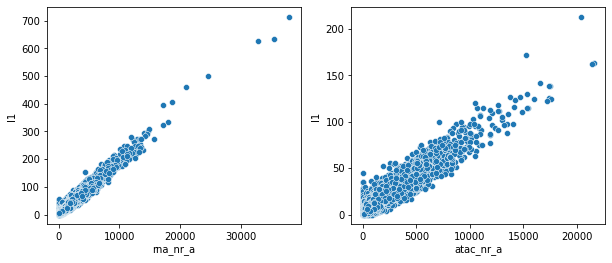

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ax = axes[0]
sns.scatterplot(gex_pd_final, x='rna_nr_a', y='I1',ax=ax)
ax = axes[1]
sns.scatterplot(atac_pd_final, x='atac_nr_a', y='I1',ax=ax)
ax = axes[1]

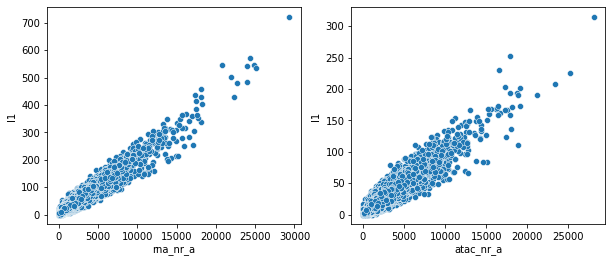

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ax = axes[0]
sns.scatterplot(gex_mux_final, x='rna_nr_a', y='I1',ax=ax)
ax = axes[1]
sns.scatterplot(atac_mux_final, x='atac_nr_a', y='I1',ax=ax)
ax = axes[1]

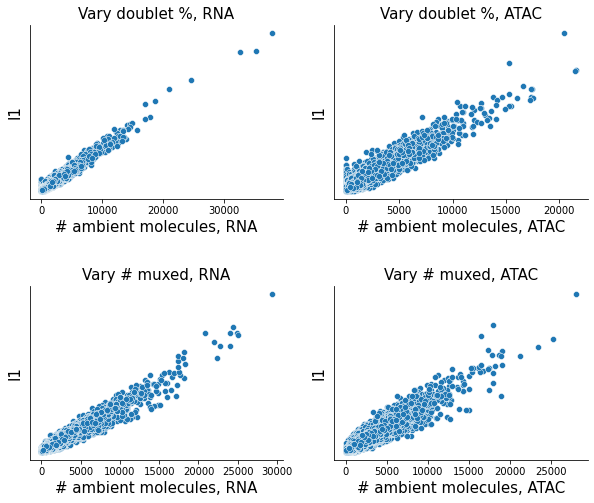

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10,8))

x_labels = ['# ambient molecules, RNA',
           '# ambient molecules, ATAC',
           '# ambient molecules, RNA',
           '# ambient molecules, ATAC']

x_ticks = ['rna_nr_a', 'atac_nr_a', 'rna_nr_a', 'atac_nr_a']
titles = ['Vary doublet %, RNA',
         'Vary doublet %, ATAC',
         'Vary # muxed, RNA',
         'Vary # muxed, ATAC',]

dfs = [gex_pd_final, atac_pd_final, gex_mux_final, atac_mux_final]


for i,ax in enumerate(axes.flatten()):
    xlab = x_labels[i]
    x = x_ticks[i]
    df = dfs[i]
    title = titles[i]
    sns.scatterplot(df, x=x, y='I1',ax=ax)
    ax.set_xlabel(xlab, size=15)
    ax.set_title(title, size=15)
#     ax.tick_params(axis='y', which='both')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylabel('I1', size=15)
    ax.spines[['right', 'top']].set_visible(False)

plt.subplots_adjust(hspace=0.5)

In [21]:
pearsonr(gex_pd_final['rna_nr_a'], gex_pd_final['I1']), \
pearsonr(gex_pd_final['atac_nr_a'], atac_pd_final['I1']), \
pearsonr(gex_pd_final['atac_nr_ap'], atac_pd_final['I1']), \
spearmanr(gex_pd_final['rna_nr_a'], gex_pd_final['I1']), \
spearmanr(gex_pd_final['atac_nr_a'], atac_pd_final['I1']), \
spearmanr(gex_pd_final['atac_nr_ap'], atac_pd_final['I1'])

((0.9731363323184132, 0.0),
 (0.9233237920134688, 0.0),
 (0.7022022117827245, 0.0),
 SpearmanrResult(correlation=0.8956722393781269, pvalue=0.0),
 SpearmanrResult(correlation=0.7846718637415162, pvalue=0.0),
 SpearmanrResult(correlation=0.6560748772686427, pvalue=0.0))

In [22]:
pearsonr(gex_mux_final['rna_nr_a'], gex_mux_final['I1']), \
pearsonr(gex_mux_final['atac_nr_a'], atac_mux_final['I1']), \
pearsonr(gex_mux_final['atac_nr_ap'], atac_mux_final['I1']), \
spearmanr(gex_mux_final['rna_nr_a'], gex_mux_final['I1']), \
spearmanr(gex_mux_final['atac_nr_a'], atac_mux_final['I1']), \
spearmanr(gex_mux_final['atac_nr_ap'], atac_mux_final['I1'])

((0.9620812937061775, 0.0),
 (0.9303862549161387, 0.0),
 (0.6737927653933014, 0.0),
 SpearmanrResult(correlation=0.9353667798016787, pvalue=0.0),
 SpearmanrResult(correlation=0.8762655549178343, pvalue=0.0),
 SpearmanrResult(correlation=0.6041238365776801, pvalue=0.0))

In [23]:
pearsonr(gex_pd_final['ambient_RNA'], gex_pd_final['I1 rate']), \
pearsonr(gex_pd_final['ambient_DNA'], atac_pd_final['I1 rate']), \
pearsonr(gex_pd_final['ambient_DNA'], gex_pd_final['I1 rate']), \
spearmanr(gex_pd_final['ambient_RNA'], gex_pd_final['I1 rate']), \
spearmanr(gex_pd_final['ambient_DNA'], atac_pd_final['I1 rate']), \
spearmanr(gex_pd_final['ambient_DNA'], atac_pd_final['I1 rate'])

((0.939038342708059, 0.0),
 (0.8379792511510168, 0.0),
 (0.5367681922161056, 0.0),
 SpearmanrResult(correlation=0.9340161528428876, pvalue=0.0),
 SpearmanrResult(correlation=0.8230273715665543, pvalue=0.0),
 SpearmanrResult(correlation=0.8230273715665543, pvalue=0.0))

In [28]:
pearsonr(gex_mux_final['ambient_RNA'], gex_mux_final['I1 rate']), \
pearsonr(gex_mux_final['ambient_DNA'], atac_mux_final['I1 rate']), \
pearsonr(atac_mux_final['ambient_DNA'], gex_mux_final['I1 rate']), \
spearmanr(gex_mux_final['ambient_RNA'], gex_mux_final['I1 rate']), \
spearmanr(gex_mux_final['ambient_DNA'], atac_mux_final['I1 rate']), \
spearmanr(atac_mux_final['ambient_DNA'], atac_mux_final['I1 rate'])

((0.8707236529958495, 0.0),
 (0.774389281171534, 0.0),
 (0.00027212450525243375, 0.9497857677771535),
 SpearmanrResult(correlation=0.8695660302774797, pvalue=0.0),
 SpearmanrResult(correlation=0.7644432101342166, pvalue=0.0),
 SpearmanrResult(correlation=0.7644432101342166, pvalue=0.0))

In [26]:
gex_pd_final.to_csv(f'{projdir}/csv/final_figures/figure5/figure_5c_gex_pd.csv', sep='\t', header=True, index=True)
atac_pd_final.to_csv(f'{projdir}/csv/final_figures/figure5/figure_5c_atac_pd.csv', sep='\t', header=True, index=True)
gex_mux_final.to_csv(f'{projdir}/csv/final_figures/figure5/figure_5c_gex_mux.csv', sep='\t', header=True, index=True)
atac_mux_final.to_csv(f'{projdir}/csv/final_figures/figure5/figure_5c_atac_mux.csv', sep='\t', header=True, index=True)